Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

### My Own Dataset

In [ ]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    url_train = 'https://raw.githubusercontent.com/oyrx/PHBS_MLF_2019_Project/master/data/train.csv'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

     |████████████████████████████████| 81kB 2.1MB/s 
     |████████████████████████████████| 266kB 2.7MB/s 
     |████████████████████████████████| 604kB 7.8MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 3.1MB 13.5MB/s 
     |████████████████████████████████| 296kB 32.2MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=48b253da6ad69149c1beca29a9e0636d7593de81716f371d1d82038294d58eab
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=291990 sha256=fa2015234b2f1f472cedc05850338eb5fb9c3a3845c39855165c462c8c942277
  Stored in directory: /root/.cache/pip/wheels/07/1c/dc/6831446f09feb8cc199ec73a0f2f0703253f6ae013a22f4be9
Successfully built htmlmin imageh

In [ ]:
# Some imports setup for the environment for python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Some imports setup for the environment for machine learnig
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Loading the dataset file and read it
url_hotel = 'https://raw.githubusercontent.com/oyrx/PHBS_MLF_2019_Project/master/data/hotel_bookings.csv'

hotel_booked = pd.read_csv(url_hotel)

print(hotel_booked.shape)
hotel_booked.head()

(119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Choosing The Target That I am Going To Predict

### Which column in my tabular dataset will I predict?

In [ ]:
# some description about reservation_status
hotel_booked['reservation_status'].describe()

count        119390
unique            3
top       Check-Out
freq          75166
Name: reservation_status, dtype: object

In [ ]:
# Derive a discrete classification target
# Drope all unuseful hotel booking
hotel_booked['reservation_status']
hotel_booked = hotel_booked.dropna(subset=['reservation_status'])

### How is my target distributed?

In [ ]:
# Define a status hotel booking as having reservation_status of  cheked out, canceled, or no show
hotel_booked['reservation_status'].describe()

count        119390
unique            3
top       Check-Out
freq          75166
Name: reservation_status, dtype: object

### My target is a classification problem:
I have derived my target as a discrete classification problem:to answer a discrete questions whether the reservation_status checked out, canceled, or no show.

### How many classes?

In [ ]:
# I can assign my target to a variable is called my_target
my_target = hotel_booked['reservation_status'] 

In [ ]:
# check for the first 10 reservation_status in my_target
my_target.head(10)

0    Check-Out
1    Check-Out
2    Check-Out
3    Check-Out
4    Check-Out
5    Check-Out
6    Check-Out
7    Check-Out
8     Canceled
9     Canceled
Name: reservation_status, dtype: object

In [ ]:
# how many numbers of nunique values are in my target column?
my_target.nunique()

3

### There are three class, and they are discrete classification problems

### Are the classes imbalanced?

In [ ]:
# value counts for each class
my_target.value_counts(normalize=True)

Check-Out    0.629584
Canceled     0.360307
No-Show      0.010110
Name: reservation_status, dtype: float64

In [ ]:
# the max value counts
my_target.value_counts(normalize=True).max()

0.6295837172292487

### Sometimes, the majority class occurs with less than 50% frequency which can be a mis-leading. In this case, if it happens, accuracy is not good as an evaluation metrix.
For my target the majority class occurs with 62% frequency, so I gues this is not too imbalanced. I could just use accuracy score as my evaluation metric if I want to deep more there are other options like precision, recall, and roc-auc. Sometimes, the majority class occurs with less than 50% frequency which can be a mis-leading. In this case, if it happens, accuracy is not good.

### Choosing My Evaluation Metrixes
In addtion to Accuracy, I am going to use Precision and Recall, Confusion-Metrix, and Classification Report.

### Begin With Cleaning Data and Exploratory Data Analysis

#### Import Wrangle

In [ ]:
# some information about the dataset
hotel_booked.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
# some some description about the dataset
hotel_booked.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [ ]:
# checking for any missing values
hotel_booked.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### Exploratory And Data Analysis(EDA)

In [ ]:
from pandas_profiling import ProfileReport
# pull the report profile for my dataset
profile = ProfileReport(hotel_booked, minimal=True).to_notebook_iframe()

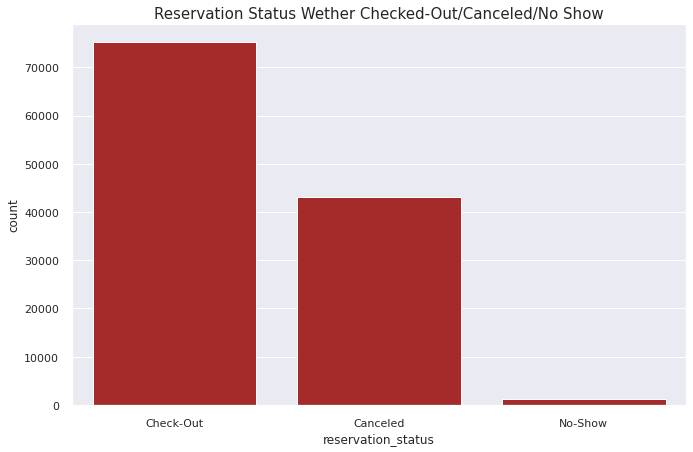

In [ ]:
# use a seaborn countplot to plot reservation_status
plt.figure(figsize= (11,7))
ax = sns.countplot(x = "reservation_status", data = hotel_booked, color='brown', saturation=2, dodge=True);
sns.set(style = "darkgrid");
plt.title("Reservation Status Wether Checked-Out/Canceled/No Show", fontdict = {'fontsize': 15});

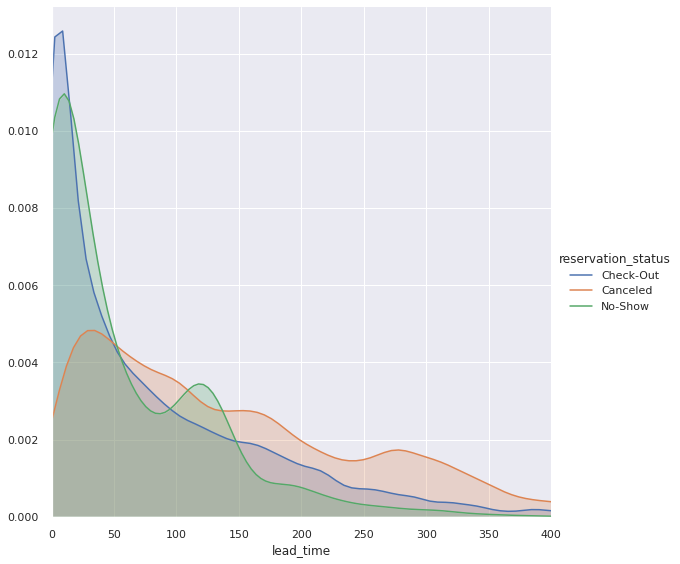

In [ ]:
# make a density curve of lead time per booking_status
lead_booking = (sns.FacetGrid(hotel_booked, hue='reservation_status', height=8, xlim=(0,400), legend_out=True).map(sns.kdeplot, 'lead_time', shade=True).add_legend());

In [ ]:
# it shows the difference of booking cancellations for th total amount of book canceled or not and the percentage(resort and city hotels)
resort_hotel = hotel_booked[hotel_booked["hotel"] == "Resort Hotel"]
city_hotel = hotel_booked[hotel_booked["hotel"] == "City Hotel"]

cancel_reso = pd.DataFrame(resort_hotel["is_canceled"].value_counts())
cancel_reso.rename(columns={"is_canceled": "booking_cancellations"}, index =({0: "No Canceled", 1:"Yes Canceled"}), inplace=True)
cancel_reso["Status"] = cancel_reso.index

cancel_city = pd.DataFrame(city_hotel["is_canceled"].value_counts())
cancel_city.rename(columns={"is_canceled": "booking_cancellations"}, index =({0: "No Canceled", 1:"Yes Canceled"}), inplace=True)
cancel_city["Status"] = cancel_city.index

# make a pie chart to show the differece book canceled for those hotels

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], subplot_titles = ["City Hotel", "Resort Hotel"])
fig.add_trace(go.Pie(values = cancel_city["booking_cancellations"], labels = cancel_city["Status"]),1,1)
fig.add_trace(go.Pie(values = cancel_reso["booking_cancellations"], labels = cancel_reso["Status"]),1,2)
fig.update_traces(textposition='inside', textinfo='value+percent+label')
fig.update_layout(title_text = "Type Of Booking Cancellations For City Hotel And Resort Hotel")
fig.show()

In [ ]:
# scatter plot between reservation_status and lead_time
px.scatter(hotel_booked, x='reservation_status', y='lead_time', color='reservation_status', opacity=0.1)

(0.0, 170.0)

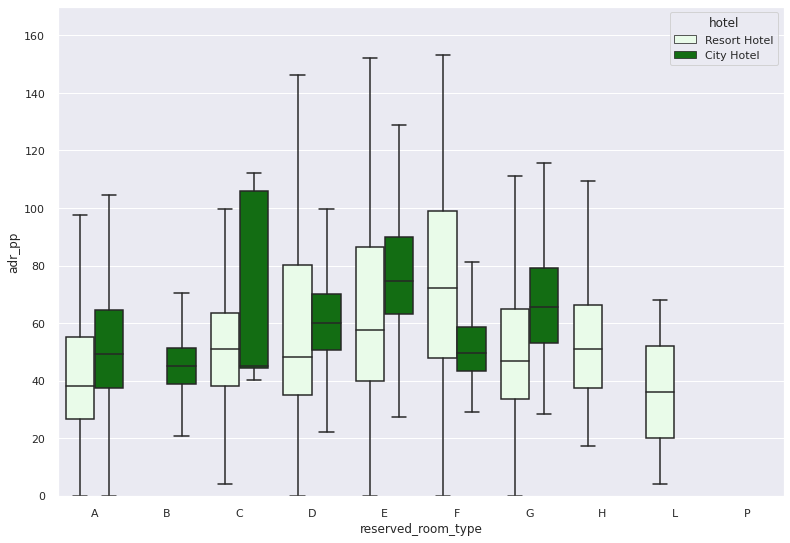

In [ ]:
# add new feature engineering from existing adr column
# make a new column called total overnight cost in each hotel for guest
hotel_booked["adr_pp"] =hotel_booked["adr"] / (hotel_booked["adults"] + hotel_booked["children"])
room_guest = hotel_booked[hotel_booked["reservation_status"]=='Canceled']
room_cost = room_guest[["hotel", "adr_pp", "reserved_room_type"]].sort_values("reserved_room_type")

plt.figure(figsize= (13,9))
sns.boxplot(x="reserved_room_type", y= "adr_pp", hue="hotel", data= room_cost, fliersize=0, color='green', saturation=0.70, width=0.8, dodge=True )
plt.ylim(0,170)

In [ ]:
hotel_booked.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_pp
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,75.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,75.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,49.0


In [ ]:
# countries that show the most total number of guests'homes for each hotel 
country_guest = pd.DataFrame(hotel_booked.loc[hotel_booked['is_repeated_guest'] == 0]["country"].value_counts())
country_guest.index.name = "country"
country_guest.rename(columns={"country": "Number of Guests"}, inplace=True)
total_num_guests = country_guest["Number of Guests"].sum()
country_guest["% Guests"] = round(country_guest["Number of Guests"] / total_num_guests * 100, 2)

In [ ]:
# country per guest shows on the map
guest_per_country = px.choropleth(country_guest,
                    locations=country_guest.index,
                    color=country_guest["% Guests"], 
                    hover_name=country_guest.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="The Majority Countries That Guests Come From")
guest_per_country.show()

### My Wrangler Data Function
I have defined a function do all cleaning data and return my_wrangler_data

In [ ]:
# define a wrangle function to deal with training, validation, and testing data
# Do some cleaning and making feature engineering
import numpy as np

def my_wrangler_data(X):
    
    # SettingWithCopyWarning
    X = X.copy()


    # replace those columns that have missing value and drop the subset of children
    null_values = {"country": "Unknown", "agent": 0, "company": 0}
    X = X.fillna(null_values)
    X.dropna(subset = ["children"], inplace = True)

    # droping all invalids entries for adults, children, babies, weekened-nights, week-night, and adr
    X.drop(X[(X["adults"] == 0) & (X["children"] == 0) & (X["babies"] == 0)].index, inplace = True)
    X.drop(X[(X["stays_in_weekend_nights"] == 0) & (X["stays_in_weekend_nights"] == 0) & (X["adr"] == 0)].index, inplace = True)
    

    # Ajdusting the some names of columns in the dataset
    X.rename(columns = {"is_canceled": "booking_cancellations","arrival_date_year":"year", "arrival_date_month":"month", "arrival_date_week_number": "week_number", "arrival_date_day_of_month":"day_of_month", "stays_in_weekend_nights":"weekend_nights", "stays_in_week_nights":"week_nights"}, inplace=True)
     

    # the different between booking cancellations in City Hotel and Resort Hotel
    resort_hotel = X[X["hotel"] == "Resort Hotel"]
    city_hotel =  X[X["hotel"] == "City Hotel"]

    cancel_reso = pd.DataFrame(resort_hotel["is_canceled"].value_counts())
    cancel_reso.rename(columns={"is_canceled": "booking_cancellations"}, index =({0: "No Canceled", 1:"Yes Canceled"}), inplace=True)
    cancel_reso["Status"] = cancel_reso.index

    cancel_city = pd.DataFrame(city_hotel["is_canceled"].value_counts())
    cancel_city.rename(columns={"is_canceled": "booking_cancellations"}, index =({0: "No Canceled", 1:"Yes Canceled"}), inplace=True)
    cancel_city["Status"] = cancel_city.index


    # countries that show the most total number of guests for each hotel
    country_guest = pd.DataFrame(X.loc[X['is_repeated_guest'] == 0]["country"].value_counts())
    country_guest.index.name = "country"
    country_guest.rename(columns={"country": "Number of Guests"}, inplace=True)
    total_num_guests = country_guest["Number of Guests"].sum()
    country_guest["% Guests"] = round(country_guest["Number of Guests"] / total_num_guests * 100, 2)

    # add new feature engineering from existing adr column
    # make a new column called total overnight cost in each hotel for guest
    X["adr_pp"] = X["adr"] / (X["adults"] + X["children"])
    room_guest = X[X["reservation_status"]==0]
    room_cost = room_guest[["hotel", "adr_pp", "reserved_room_type"]].sort_values("reserved_room_type")

   
    # drop the reservation_status from the previous dataset
    X.drop('reservation_status', axis=1, inplace=True)


    # return my wrangler data function
    return X
  

    # Loading the dataset file and read it
    url_hotel = 'https://raw.githubusercontent.com/oyrx/PHBS_MLF_2019_Project/master/data/hotel_bookings.csv'

    hotel_booked = my_wrangler_data(pd.read_csv(url_hotel))


    # treat all my dataset at the same way for training, validation, and testing
    train = my_wrangler_data(train)
    val = my_wrangler_data(val)
    test = my_wrangler_data(test)

In [ ]:
 hotel_booked['reservation_status']

0         Check-Out
1         Check-Out
2         Check-Out
3         Check-Out
4         Check-Out
            ...    
119385    Check-Out
119386    Check-Out
119387    Check-Out
119388    Check-Out
119389    Check-Out
Name: reservation_status, Length: 119390, dtype: object

### Choose which observations I will use to train, validate, and test my model

### Split Data

In [ ]:
# Split my feature matrix and target vector
y = hotel_booked['reservation_status']
X = hotel_booked.drop(['reservation_status'], axis=1)

In [ ]:
# train on reviews from 2015 & earlier. Validate on 2016. Test on 2017 & later
hotel_booked['reservation_status_date'] = pd.to_datetime(hotel_booked['reservation_status_date'])
train = hotel_booked[hotel_booked['reservation_status_date'].dt.year <= 2015]
val = hotel_booked[hotel_booked['reservation_status_date'].dt.year == 2016]
test =hotel_booked[hotel_booked['reservation_status_date'].dt.year >= 2017]

In [ ]:
# prrint out all shapes for training data and validation data
print(train.shape)
print(train.shape)
print(val.shape)
print(val.shape)
print(test.shape)
print(test.shape)

(25110, 33)
(25110, 33)
(57797, 33)
(57797, 33)
(36483, 33)
(36483, 33)


### Begin to choose which features, if any, to exclude

In [ ]:
# Selecting features
# The booking_status column is the my target
my_target = 'reservation_status'
 
# Get a dataframe with all train columns except the target and the high cardinalities
train_features = hotel_booked.columns.drop([my_target], 'reservation_status_date')

# Get a list of the numerical features and categorical_features
numerical_features = ['total_of_special_requests', 'lead_time', 'is_repeated_guest', 'previous_cancellations','previous_bookings_not_canceled',
                      'stays_in_week_nights', 'required_car_parking_spaces']
categorical_features = ['arrival_date_month', 'deposit_type', 'reserved_room_type','hotel', 'customer_type',
 'market_segment', 'meal']
 
# Combine all the lists 
my_features = numerical_features + categorical_features

In [ ]:
# Arrange data into features matrix and target vector 
X_train = train[my_features]
y_train = train[my_target]
X_val = val[my_features]
y_val = val[my_target]
X_test = test[my_features]
y_test = test[my_target]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(25110, 14)
(25110,)
(57797, 14)
(57797,)
(36483, 14)
(36483,)


In [ ]:
# selecting some features to have in the future
my_features

['total_of_special_requests',
 'lead_time',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'stays_in_week_nights',
 'required_car_parking_spaces',
 'arrival_date_month',
 'deposit_type',
 'reserved_room_type',
 'hotel',
 'customer_type',
 'market_segment',
 'meal']

### BaseLine

In [ ]:
# initial baseline traing, validation, and testing data that just to help me what I can predict for my building models
print('Baseline Training Accuracy:', y_train.value_counts(normalize=True).max())
print('Baseline Training Accuracy:', y_val.value_counts(normalize=True).max())
print('Baseline Training Accuracy:', y_test.value_counts(normalize=True).max())

Baseline Training Accuracy: 0.536121067303863
Baseline Training Accuracy: 0.6292541135353046
Baseline Training Accuracy: 0.6944330236000329


In [ ]:
# appropriator importance estimators to setup python enironment
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.scorer import check_scoring  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
#from eli5.permutation_importance import get_score_importances
#from eli5.sklearn.utils import pandas_available

#### On One Hot Encoder

In [ ]:
# one hot encoder on all the non-numerical columns
encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
Logistic_model = LogisticRegression(max_iter=1000)

X_train_encoded = encoder.fit_transform(X_train)
X_train_encoded.head()

,total_of_special_requests,lead_time,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,stays_in_week_nights,required_car_parking_spaces,arrival_date_month_July,arrival_date_month_August,arrival_date_month_September,arrival_date_month_October,arrival_date_month_November,arrival_date_month_December,arrival_date_month_January,arrival_date_month_February,arrival_date_month_March,arrival_date_month_April,arrival_date_month_May,arrival_date_month_June,deposit_type_No Deposit,deposit_type_Refundable,deposit_type_Non Refund,reserved_room_type_C,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_G,reserved_room_type_F,reserved_room_type_H,reserved_room_type_L,reserved_room_type_B,hotel_Resort Hotel,hotel_City Hotel,customer_type_Transient,customer_type_Contract,customer_type_Transient-Party,customer_type_Group,market_segment_Direct,market_segment_Corporate,market_segment_Online TA,market_segment_Offline TA/TO,market_segment_Complementary,market_segment_Groups,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined
0,0,342,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,737,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,7,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,13,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1,14,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


## Building The Model With Decision Tree

In [ ]:
tree_model = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       DecisionTreeClassifier())

### Would some features “leak” future information?

In [ ]:
tree_model

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=None, drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=None, return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_...d=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None

In [ ]:
# Fitting the tree_model 
tree_model.fit(X_train, y_train);

In [ ]:
# Check Evaluation Metrics for the tree_model
print('Traing Accuracy:', tree_model.score(X_train, y_train))
print('Validation Accuracy:', tree_model.score(X_val, y_val))

Traing Accuracy: 0.9743130227001194
Validation Accuracy: 0.5218263923733065


### No, all my traing, validation, and testing data show less than a  %100 accuracy.
So, that mean some features “not very leak” future information. So, that was really good to check your accuracy. I can say If I got a  %100 or close to it that means I was doing something wrong, and I shoud fix it first and move on the next step by droping that colum cause leakage. But in my case, there is no leakage.

In [ ]:
# Get the insight of the tree model
classifier = tree_model.named_steps['decisiontreeclassifier']
feature_names = tree_model.named_steps['ordinalencoder'].feature_names

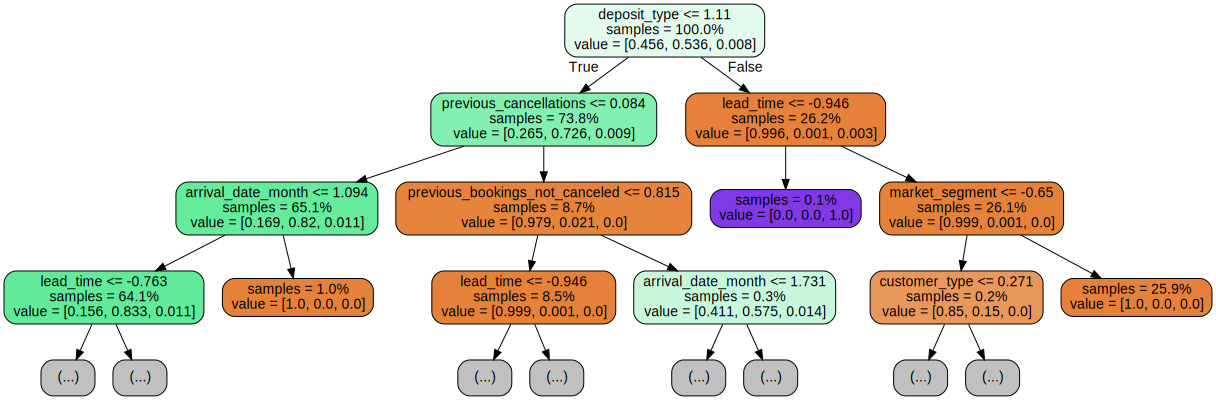

In [ ]:
# Making  a visualization for the tree
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(classifier, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=feature_names,
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

### Building Model With Logistic

In [ ]:
Logistic_model = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       LogisticRegression(max_iter=1000)
)

In [ ]:
# Fitting the tree_model 
Logistic_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['arrival_date_month', 'deposit_type',
                                      'reserved_room_type', 'hotel',
                                      'customer_type', 'market_segment',
                                      'meal'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'arrival_date_month',
                                          'data_type': dtype('O'),
                                          'mapping': July          1
August        2
September     3
October       4
November      5
D...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,


In [ ]:
# Check Evaluation Metrics for the logistic_model
print('Traing Accuracy:', Logistic_model.score(X_train, y_train))
print('Validation Accuracy:', Logistic_model.score(X_val, y_val))
print('Testing Accuracy:', Logistic_model.score(X_test, y_test))

Traing Accuracy: 0.8813221823974512
Validation Accuracy: 0.7293631157326504
Testing Accuracy: 0.7460461036647206


### Build The Model With RandomForest

In [ ]:
# Make pipeline as a one package for all
Rand_forest = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
)

In [ ]:
# Fitting the tree_model 
Rand_forest.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['arrival_date_month', 'deposit_type',
                                      'reserved_room_type', 'hotel',
                                      'customer_type', 'market_segment',
                                      'meal'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'arrival_date_month',
                                          'data_type': dtype('O'),
                                          'mapping': July          1
August        2
September     3
October       4
November      5
D...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max

In [ ]:
# Check Evaluation Metrics for the Rand_forest
print('Traing Accuracy:', Rand_forest.score(X_train, y_train))
print('Validation Accuracy:', Rand_forest.score(X_val, y_val))

Traing Accuracy: 0.9738749502190363
Validation Accuracy: 0.5499420385141097


### Importance Features

### With RandomForest Top 20 Importance Features

In [ ]:
# make top 20 feature importances withe randomforst
classifier= Rand_forest.named_steps['randomforestclassifier']
f_importances = pd.Series(classifier.feature_importances_, X_train.columns)

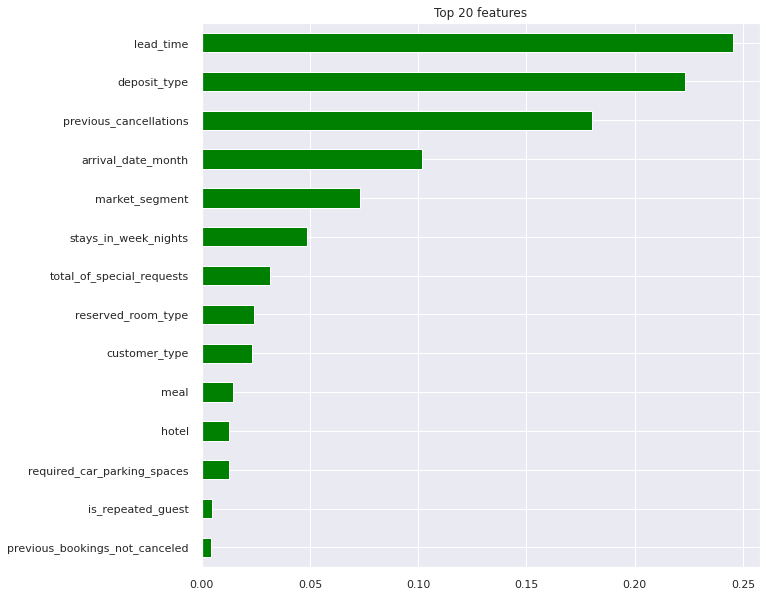

In [ ]:
# plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
f_importances.sort_values()[-n:].plot.barh(color='green');

### With Decision Tree Top 10 Importance Features

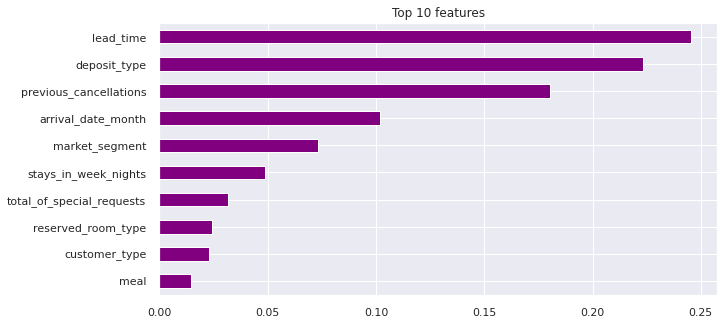

In [ ]:
# Importance features of my tree to get the top 10 features
import matplotlib.pyplot as plt

# Get the insight of the tree model
classifier = tree_model.named_steps['decisiontreeclassifier']

feature_names = tree_model.named_steps['ordinalencoder'].feature_names

features_importances = classifier.feature_importances_
importances = pd.Series(features_importances, index=feature_names)

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
f_importances.sort_values()[-n:].plot.barh(color='purple');

In [ ]:
# Predictor
y_pred = Logistic_model.predict(X_val)
y_pred

array(['Canceled', 'Check-Out', 'Check-Out', ..., 'Check-Out',
       'Check-Out', 'Check-Out'], dtype=object)

### Accuracy/Precision/ And Recall



In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.7293631157326504

In [ ]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_val, y_pred, average='micro')

0.7293631157326504

In [ ]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_val, y_pred, pos_label=1, average='weighted' )

0.7293631157326504

### Tuning and Hyper Parametters

In [ ]:
# Make pipeline as a one package for all
Rand_model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
)

In [ ]:
# using hyperparametter for RandomForest
paramtter = {'simpleimputer__strategy':['mean', 'most_frequent', 'median'],
             
             'randomforestclassifier__n_estimators': [5,10,20],
             'randomforestclassifier__criterion': ['gini','entropy'],  
             'randomforestclassifier__min_samples_split': [5,10,20],
             'randomforestclassifier__max_depth': [4,10,15], 
             'randomforestclassifier__min_samples_leaf': [5,10,20]}

In [ ]:
research_r= RandomizedSearchCV(Rand_model,
                  param_distributions=paramtter,
                  n_iter=3,
                  n_jobs=-1,
                  return_train_score=True,
                  scoring='accuracy',
                  verbose=1,
                  cv=4)

In [ ]:
# fitting the model
research_r.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.4s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
research_r.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_leaf': 20,
 'randomforestclassifier__min_samples_split': 20,
 'randomforestclassifier__n_estimators': 20,
 'simpleimputer__strategy': 'median'}

In [ ]:
best_rand_search = research_r.best_score_
best_rand_search

0.8138621974985869

In [ ]:
best_estimator = research_r.best_params_

In [ ]:
best_model_estimator = research_r.best_estimator_

In [ ]:
print("Best Score:", research_r.best_score_ )

Best Score: 0.8138621974985869


In [ ]:
print("Best Model:", research_r.best_estimator_)
print("Best Estimator:", research_r.best_params_)

Best Model: Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['arrival_date_month', 'deposit_type',
                                      'reserved_room_type', 'hotel',
                                      'customer_type', 'market_segment',
                                      'meal'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'arrival_date_month',
                                          'data_type': dtype('O'),
                                          'mapping': July          1
August        2
September     3
October       4
November      5
D...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                 

### Permutation & Boosting

### Xgboost For Gradient Boosting
It is with early stopping to prevent the overfitting and underfitting, and it is optimized hyperparametters with the best estimators. Also it helps to improve the model and select feature importances.

In [ ]:
from xgboost import XGBClassifier

xgb_model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    XGBClassifier(n_jobs=10, early_stopping_rounds=10)
)

In [ ]:
xgb_model.fit(X_train, y_train);

In [ ]:
print('Training Accuracy:', xgb_model.score(X_train, y_train))
print('Validation Accuracy:', xgb_model.score(X_val, y_val))

Training Accuracy: 0.8950617283950617
Validation Accuracy: 0.5753931864975691


In [ ]:
from xgboost.sklearn import XGBClassifier
from sklearn.inspection import permutation_importance

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [ ]:
model_xgoost = XGBClassifier(n_estimators =20,
                             max_depth =5, 
                             learning_rate = .5,
                             n_jobs = -1)
evel_set = ((X_train_encoded, y_train),
(X_val_encoded, y_val)), (X_test_encoded, y_test)

In [ ]:
model_xgoost.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print('Training Accuracy:', model_xgoost.score(X_train_encoded, y_train))
print('Validation Accuracy:', model_xgoost.score(X_val_encoded, y_val))

Training Accuracy: 0.9019115890083632
Validation Accuracy: 0.5807913905566033


### Permutation Importance
Permutation Importance, I think it is very useful if we compromise between feature importance for reduction that it can be best or fastest.

In [ ]:
#XGBoosting with hyperparametters

paramet = {
    'criterion': 'giny', 
    'learning_rate': 0.04, 
    'max_depth': 5,
    'n_estimators': 200, 
    'objective': 'binary:logistic', 
}

In [ ]:
#XGB model
model_xgoost= XGBClassifier(parameters=paramet)

# fit the model
model_xgoost.fit(X_train_encoded, y_train)

# perform permutation importance
xgb_result = permutation_importance(model_xgoost, X_train_encoded, y_train, scoring='accuracy', n_repeats = 10, n_jobs=-1)
xgb_in = xgb_result.importances_mean.argsort()

In [ ]:
# make table scores for features by using a for loop
for i,j in enumerate(xgb_in):
    print("Feature Scores: %0d, Score: %.5f " % (i,j))

Feature Scores: 0, Score: 9.00000 
Feature Scores: 1, Score: 2.00000 
Feature Scores: 2, Score: 0.00000 
Feature Scores: 3, Score: 10.00000 
Feature Scores: 4, Score: 13.00000 
Feature Scores: 5, Score: 6.00000 
Feature Scores: 6, Score: 5.00000 
Feature Scores: 7, Score: 11.00000 
Feature Scores: 8, Score: 4.00000 
Feature Scores: 9, Score: 12.00000 
Feature Scores: 10, Score: 1.00000 
Feature Scores: 11, Score: 7.00000 
Feature Scores: 12, Score: 8.00000 
Feature Scores: 13, Score: 3.00000 


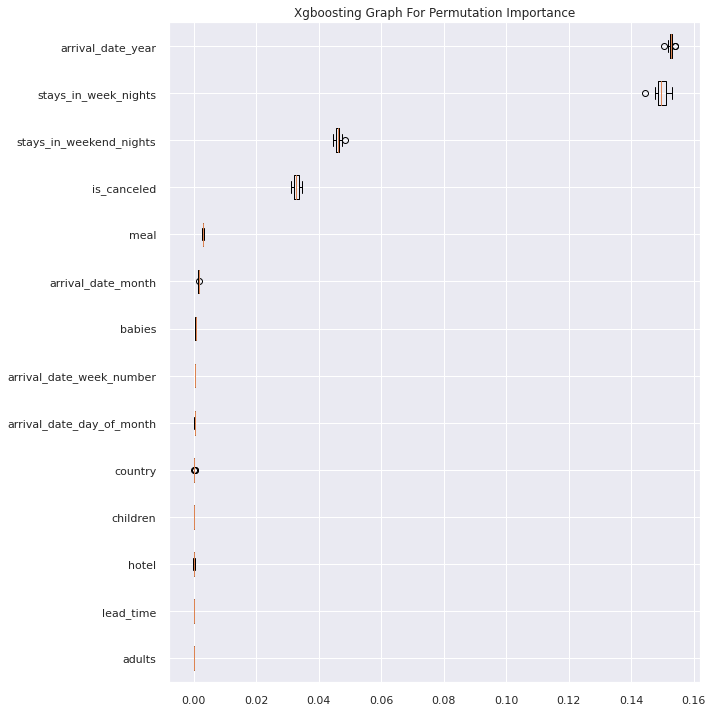

In [ ]:
# Xgboosting graph for permutation importance

fig, ax = plt.subplots(figsize=(10,10))

ax.boxplot(xgb_result.importances[xgb_in].T,
           vert=False, labels=X.columns[xgb_in])
ax.set_title("Xgboosting Graph For Permutation Importance")
fig.tight_layout()
plt.show()

In [ ]:
# tree decision model
tree_model1 = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       DecisionTreeClassifier(criterion= 'gini', min_samples_split=9,
                                  min_samples_leaf = 5, max_features = 'auto'))

# fit the model
tree_model1.fit(X_train_encoded, y_train);

In [ ]:
#Predict Model
predict_tree = tree_model1.predict(X_test_encoded)

predict_tree 

array(['Canceled', 'Check-Out', 'Canceled', ..., 'Check-Out', 'Check-Out',
       'Check-Out'], dtype=object)

In [ ]:
# logistic model
Logistic_model1 = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       LogisticRegression(max_iter=1000)
)

# fit the model
Logistic_model1.fit(X_train_encoded, y_train);

In [ ]:
#Predict Model
predict_log = Logistic_model.predict(X_test_encoded)

predict_log 

array(['Check-Out', 'Check-Out', 'Check-Out', ..., 'Check-Out',
       'Check-Out', 'Check-Out'], dtype=object)

In [ ]:
# Randforest model
Rand_forest1 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1
                           , min_samples_leaf = 7, min_samples_split=8)
)

# fit the model
Rand_forest1.fit(X_train_encoded, y_train);

In [ ]:
#Predict Model
predict_randf = Rand_forest1.predict(X_test_encoded)

predict_randf 

array(['Canceled', 'Canceled', 'Canceled', ..., 'Check-Out', 'Check-Out',
       'Check-Out'], dtype=object)

In [ ]:
# extreme gradient boosting to predict the model 
model_xgoost = XGBClassifier(criterion = 'giny', learning_rate = 0.02, max_depth = 6, n_estimators = 200,
                          objective ='binary:logistic', subsample = 1.0)
# fit the model
model_xgoost.fit(X_train_encoded, y_train);

In [ ]:
#Predict Model
predict_xgb  = model_xgoost.predict(X_test_encoded)

predict_xgb 

array(['Canceled', 'Canceled', 'Canceled', ..., 'Check-Out', 'Check-Out',
       'Check-Out'], dtype=object)

### Classification Reports For Models

In [ ]:
# Classification Reports for all models
print("Decision Tree Model", classification_report(y_test, predict_tree))
print("Logistic Model",classification_report(y_test, predict_log))
print("Random Forest Model", classification_report(y_test, predict_randf))
print("XGBoosting", classification_report(y_test, predict_xgb))

Decision Tree Model               precision    recall  f1-score   support

    Canceled       0.38      0.63      0.47     10800
   Check-Out       0.77      0.56      0.65     25335
     No-Show       0.00      0.00      0.00       348

    accuracy                           0.57     36483
   macro avg       0.38      0.39      0.37     36483
weighted avg       0.65      0.57      0.59     36483



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Logistic Model               precision    recall  f1-score   support

    Canceled       0.56      0.00      0.00     10800
   Check-Out       0.69      1.00      0.82     25335
     No-Show       0.00      0.00      0.00       348

    accuracy                           0.69     36483
   macro avg       0.42      0.33      0.27     36483
weighted avg       0.65      0.69      0.57     36483

Random Forest Model               precision    recall  f1-score   support

    Canceled       0.30      0.73      0.43     10800
   Check-Out       0.71      0.29      0.41     25335
     No-Show       0.00      0.00      0.00       348

    accuracy                           0.42     36483
   macro avg       0.34      0.34      0.28     36483
weighted avg       0.58      0.42      0.41     36483

XGBoosting               precision    recall  f1-score   support

    Canceled       0.31      0.71      0.43     10800
   Check-Out       0.73      0.33      0.46     25335
     No-Show       0.08      

### Confusion Matrix For Models

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Confusion Matrix 
tree_matrix = confusion_matrix(y_test, predict_tree)
log_matrix = confusion_matrix(y_test, predict_log)
randf_matrix = confusion_matrix(y_test, predict_randf)
xgb_matrix = confusion_matrix(y_test, predict_xgb)

### Plot All The Confusion Matrixes

Text(564.5454545454544, 0.5, 'Actual Labels')

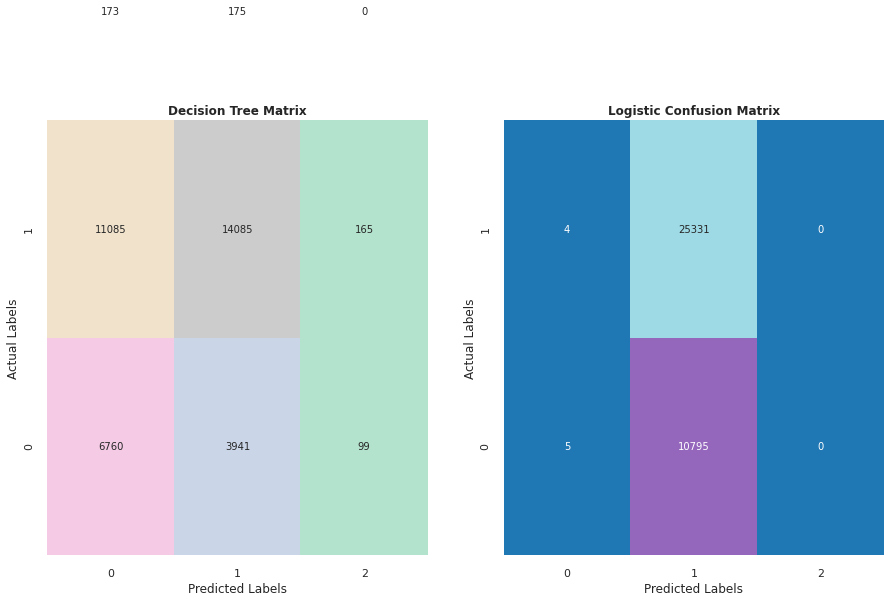

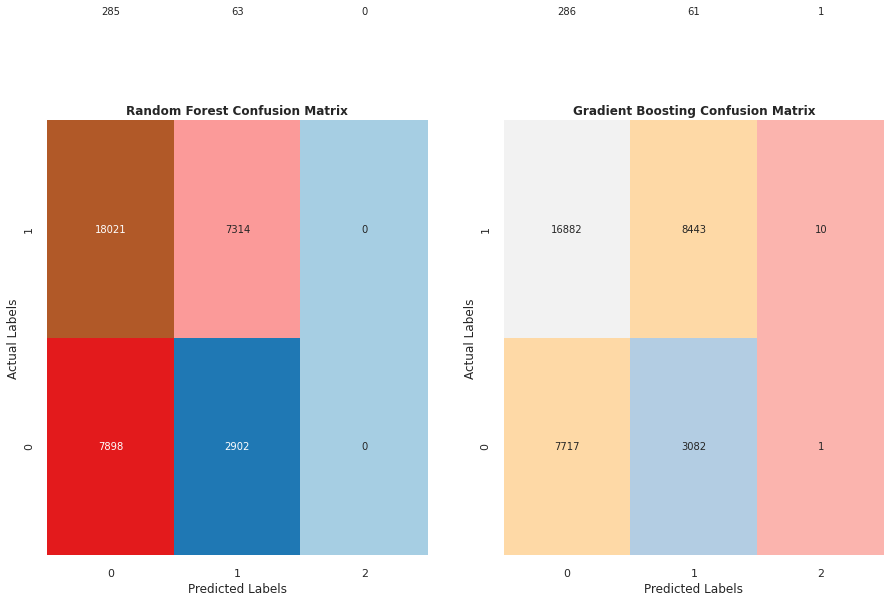

In [ ]:
# plot all the confusion matrixes
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

sns.heatmap(tree_matrix,annot=True, fmt="d", cbar=False, cmap="Pastel2",  ax = ax[0]).set_ylim([0,2])
ax[0].set_title("Decision Tree Matrix", weight='bold')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('Actual Labels')

sns.heatmap(log_matrix ,annot=True, fmt="d" ,cbar=False, cmap="tab20", ax = ax[1]).set_ylim([0,2])
ax[1].set_title("Logistic Confusion Matrix", weight='bold')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('Actual Labels')

fig, axe = plt.subplots(1, 2, figsize=(15, 8))

sns.heatmap(randf_matrix,annot=True, fmt="d", cbar=False, cmap="Paired", ax = axe[0]).set_ylim([0,2])
axe[0].set_title("Random Forest Confusion Matrix", weight='bold')
axe[0].set_xlabel('Predicted Labels')
axe[0].set_ylabel('Actual Labels')

sns.heatmap(xgb_matrix ,annot=True, fmt="d", cbar=False, cmap="Pastel1", ax = axe[1]).set_ylim([0,2])
axe[1].set_title("Gradient Boosting Confusion Matrix", weight='bold')
axe[1].set_xlabel('Predicted Labels')
axe[1].set_ylabel('Actual Labels')

In [ ]:
# importance feature with eli
eli_transformer = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

In [ ]:
X_train_transformed = eli_transformer.fit_transform(X_train)
X_val_transformed = eli_transformer.transform(X_val)

eli_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
eli_model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
print('Training Accuracy:', eli_model.score(X_train_transformed, y_train))
print('Validation Accuracy:', eli_model.score(X_val_transformed , y_val))

Training Accuracy: 0.9743130227001194
Validation Accuracy: 0.5520182708445075


In [ ]:
# get a series of importance features
feature_names = X_val.columns.tolist()
pd.Series(eli_model.feature_importances_, feature_names).sort_values()

is_repeated_guest                 0.003735
previous_bookings_not_canceled    0.003946
required_car_parking_spaces       0.012078
meal                              0.014416
hotel                             0.016905
reserved_room_type                0.022564
total_of_special_requests         0.027961
customer_type                     0.030650
stays_in_week_nights              0.047602
market_segment                    0.067347
arrival_date_month                0.096678
previous_cancellations            0.197184
deposit_type                      0.212174
lead_time                         0.246761
dtype: float64

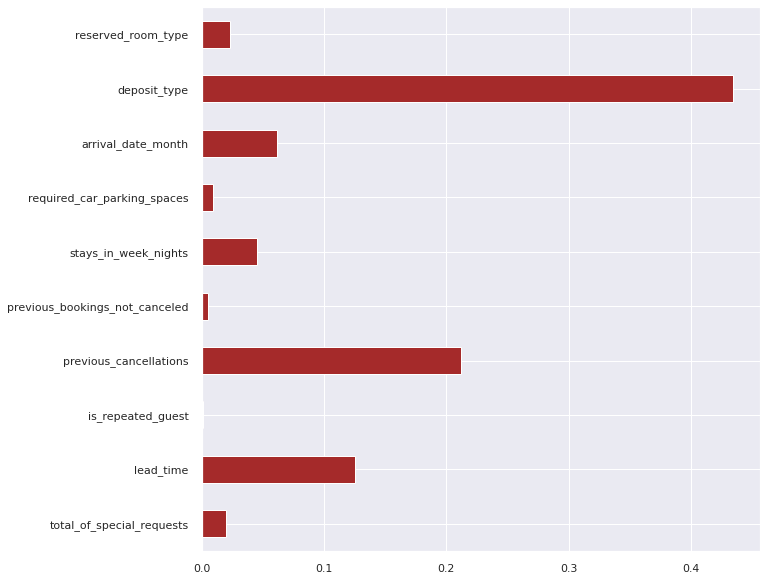

In [ ]:
plt.figure(figsize=(10,10))
importances.head(10).plot(kind='barh', stacked=True, color='brown');

### The Permutation Importances For All Feature Wit Eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
# show the permutation importances for all features 
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)